In [258]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', None)

In [259]:
from matplotlib.colors import LinearSegmentedColormap

colors = ["darkred", "firebrick", "red", "lightcoral", "salmon"]
cmap = LinearSegmentedColormap.from_list("custom_fire", colors, N=5)

In [260]:
m = pd.read_csv('./ph_fires_matched_1.1.csv')

In [261]:
def get_last_building_fire(row, last_year):
    for year in range(last_year, 2011, -1): 
        if row[f'building_fires_{year}'] > 0:
            return year
    return -1

def get_last_severe_fire(row, last_year):
    for year in range(last_year, 2011, -1): 
        if ((row[f'inc_type_111_{year}'] > 0) or
           (row[f'oth_inj_{year}'] > 0) or
           (row[f'oth_death_{year}'] > 0) or
           (row[f'prop_loss_{year}'] > 0) or
           (row[f'cont_loss_{year}'] > 0)):
            return year
    return -1

def get_last_loss_fire(row, last_year):
    for year in range(last_year, 2011, -1): 
        if ((row[f'oth_inj_{year}'] > 0) or
           (row[f'oth_death_{year}'] > 0) or
           (row[f'prop_loss_{year}'] > 0) or
           (row[f'cont_loss_{year}'] > 0)):
            return year
    return -1

In [262]:
# l = m[(m.building_type_code_es == 1) | (m.addr_type_h)].copy()
# # l = m

# prevs = []
# for year in range(2021, 2012, -1):
#     yearly_fires = l[l[f'building_fires_{year}'] > 0].copy()
#     yearly_fires['last_fire'] = yearly_fires.apply(get_last_severe_fire, args=(year - 1,), axis=1)
#     print(year, 'Total fires:', len(yearly_fires))
#     display(yearly_fires.groupby('last_fire').size().sort_values(ascending=False))
#     percent_with_prev = len(yearly_fires[yearly_fires.last_fire > 0]) / len(yearly_fires)
#     prevs.append((year, percent_with_prev))
#     print(f'% of total {year} fires with a previous fire:', percent_with_prev)
#     print()


### Looking when the last fire was for public housing buildings

ES, 2021, last damaging fire

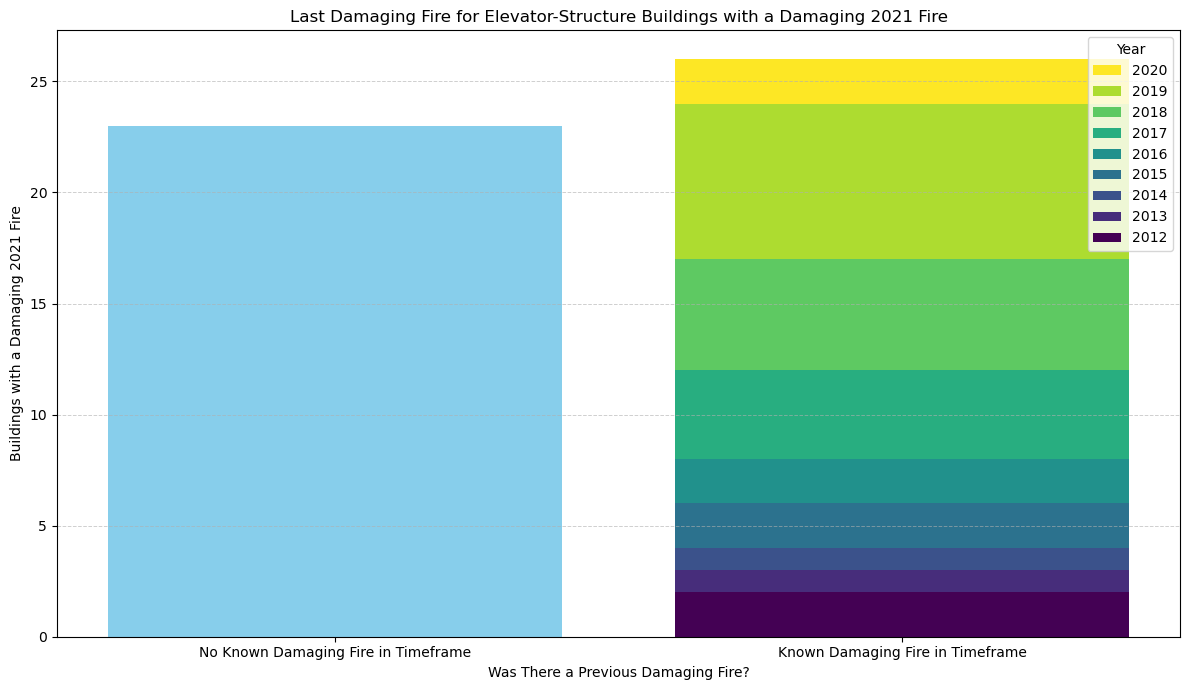

In [263]:
year = 2021
lookback = m[
    (
    (m[f'oth_inj_{year}'] > 0) |
    (m[f'oth_death_{year}'] > 0) |
    (m[f'prop_loss_{year}'] > 0) |
    (m[f'cont_loss_{year}'] > 0)) &

    (m.building_type_code_es == 1) 
].copy()

lookback['last_fire'] = lookback.apply(get_last_loss_fire, args=(year - 1,), axis=1)

lookback['last_fire'] = lookback['last_fire'].astype(str)
lookback.last_fire = lookback.last_fire.replace('-1', 'None in Timeframe')

lookbackvals = lookback.groupby('last_fire').size().reset_index()

# Separate "None After 2012" from the rest and concatenate them in the desired order
none_after_2012 = lookbackvals[lookbackvals['last_fire'] == 'None in Timeframe']
others = lookbackvals[lookbackvals['last_fire'] != 'None in Timeframe'].sort_values(by='last_fire')

lookbackvals_sorted = pd.concat([none_after_2012, others])

plt.figure(figsize=(12, 7))

none_val = none_after_2012[0].values[0]
plt.bar("No Known Damaging Fire in Timeframe", none_val, color='skyblue')

bottom_val = 0  
colors = plt.cm.viridis(np.linspace(0, 1, len(others))) 
for index, row in others.iterrows():
    plt.bar("Known Damaging Fire in Timeframe", row[0], bottom=bottom_val, color=colors[index], label=row['last_fire'])
    bottom_val += row[0]

plt.xlabel('Was There a Previous Damaging Fire?')
plt.ylabel('Buildings with a Damaging 2021 Fire')
plt.title('Last Damaging Fire for Elevator-Structure Buildings with a Damaging 2021 Fire')
plt.legend(title="Year", loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Year", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

Non-ES, 2021, damaging fire

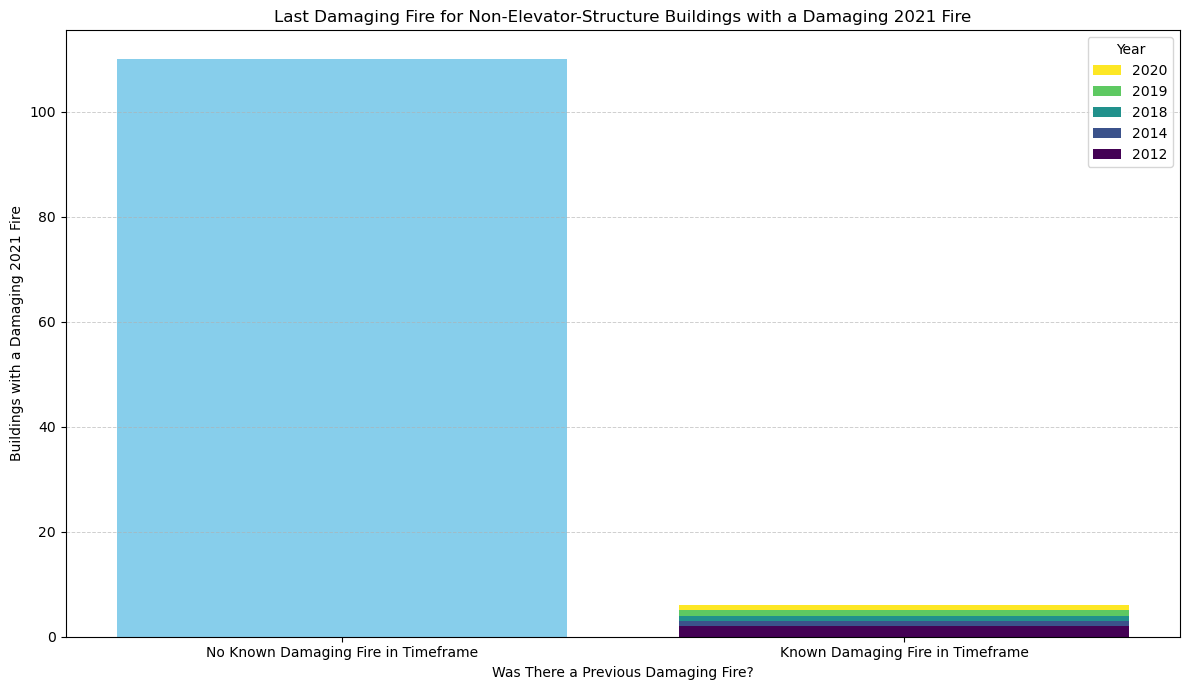

In [264]:
year = 2021
lookback = m[
    (
    (m[f'oth_inj_{year}'] > 0) |
    (m[f'oth_death_{year}'] > 0) |
    (m[f'prop_loss_{year}'] > 0) |
    (m[f'cont_loss_{year}'] > 0)) &

    (m.building_type_code_es != 1) 
].copy()

lookback['last_fire'] = lookback.apply(get_last_loss_fire, args=(year - 1,), axis=1)

lookback['last_fire'] = lookback['last_fire'].astype(str)
lookback.last_fire = lookback.last_fire.replace('-1', 'None in Timeframe')

lookbackvals = lookback.groupby('last_fire').size().reset_index()

# Separate "None After 2012" from the rest and concatenate them in the desired order
none_after_2012 = lookbackvals[lookbackvals['last_fire'] == 'None in Timeframe']
others = lookbackvals[lookbackvals['last_fire'] != 'None in Timeframe'].sort_values(by='last_fire')

lookbackvals_sorted = pd.concat([none_after_2012, others])

plt.figure(figsize=(12, 7))

none_val = none_after_2012[0].values[0]
plt.bar("No Known Damaging Fire in Timeframe", none_val, color='skyblue')

bottom_val = 0  
colors = plt.cm.viridis(np.linspace(0, 1, len(others))) 
for index, row in others.iterrows():
    plt.bar("Known Damaging Fire in Timeframe", row[0], bottom=bottom_val, color=colors[index], label=row['last_fire'])
    bottom_val += row[0]

plt.xlabel('Was There a Previous Damaging Fire?')
plt.ylabel('Buildings with a Damaging 2021 Fire')
plt.title('Last Damaging Fire for Non-Elevator-Structure Buildings with a Damaging 2021 Fire')
plt.legend(title="Year", loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Year", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

Damaging or unconfined fire, 2021, ES

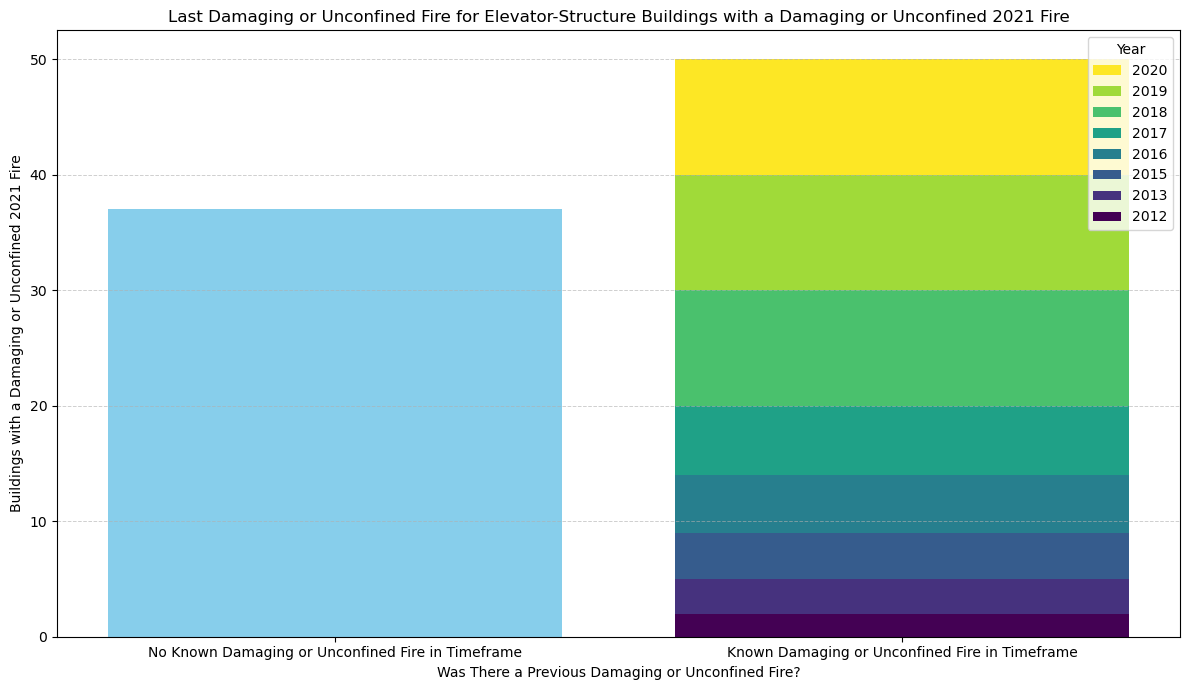

In [265]:
year = 2021
lookback = m[
    ((m[f'inc_type_111_{year}'] > 0) |
    (m[f'oth_inj_{year}'] > 0) |
    (m[f'oth_death_{year}'] > 0) |
    (m[f'prop_loss_{year}'] > 0) |
    (m[f'cont_loss_{year}'] > 0)) &

    (m.building_type_code_es == 1) 
].copy()

lookback['last_fire'] = lookback.apply(get_last_severe_fire, args=(year - 1,), axis=1)

lookback['last_fire'] = lookback['last_fire'].astype(str)
lookback.last_fire = lookback.last_fire.replace('-1', 'None in Timeframe')

lookbackvals = lookback.groupby('last_fire').size().reset_index()

# Separate "None After 2012" from the rest and concatenate them in the desired order
none_after_2012 = lookbackvals[lookbackvals['last_fire'] == 'None in Timeframe']
others = lookbackvals[lookbackvals['last_fire'] != 'None in Timeframe'].sort_values(by='last_fire')

lookbackvals_sorted = pd.concat([none_after_2012, others])

plt.figure(figsize=(12, 7))

none_val = none_after_2012[0].values[0]
plt.bar("No Known Damaging or Unconfined Fire in Timeframe", none_val, color='skyblue')

bottom_val = 0  
colors = plt.cm.viridis(np.linspace(0, 1, len(others))) 
for index, row in others.iterrows():
    plt.bar("Known Damaging or Unconfined Fire in Timeframe", row[0], bottom=bottom_val, color=colors[index], label=row['last_fire'])
    bottom_val += row[0]

plt.xlabel('Was There a Previous Damaging or Unconfined Fire?')
plt.ylabel('Buildings with a Damaging or Unconfined 2021 Fire')
plt.title('Last Damaging or Unconfined Fire for Elevator-Structure Buildings with a Damaging or Unconfined 2021 Fire')
plt.legend(title="Year", loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Year", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

Non-ES, 2021, unconfined or damaging

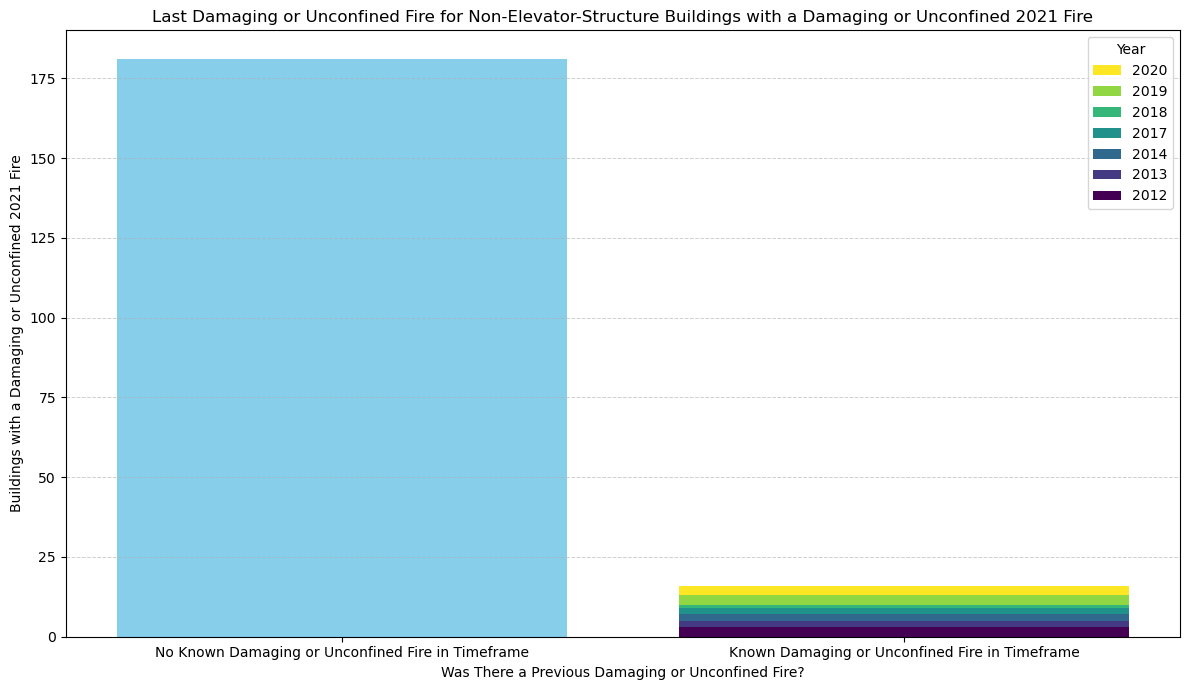

In [266]:
year = 2021
lookback = m[
    ((m[f'inc_type_111_{year}'] > 0) |
    (m[f'oth_inj_{year}'] > 0) |
    (m[f'oth_death_{year}'] > 0) |
    (m[f'prop_loss_{year}'] > 0) |
    (m[f'cont_loss_{year}'] > 0)) &

    (m.building_type_code_es != 1) 
].copy()

lookback['last_fire'] = lookback.apply(get_last_severe_fire, args=(year - 1,), axis=1)

lookback['last_fire'] = lookback['last_fire'].astype(str)
lookback.last_fire = lookback.last_fire.replace('-1', 'None in Timeframe')

lookbackvals = lookback.groupby('last_fire').size().reset_index()

# Separate "None After 2012" from the rest and concatenate them in the desired order
none_after_2012 = lookbackvals[lookbackvals['last_fire'] == 'None in Timeframe']
others = lookbackvals[lookbackvals['last_fire'] != 'None in Timeframe'].sort_values(by='last_fire')

lookbackvals_sorted = pd.concat([none_after_2012, others])

plt.figure(figsize=(12, 7))

none_val = none_after_2012[0].values[0]
plt.bar("No Known Damaging or Unconfined Fire in Timeframe", none_val, color='skyblue')

bottom_val = 0  
colors = plt.cm.viridis(np.linspace(0, 1, len(others))) 
for index, row in others.iterrows():
    plt.bar("Known Damaging or Unconfined Fire in Timeframe", row[0], bottom=bottom_val, color=colors[index], label=row['last_fire'])
    bottom_val += row[0]

plt.xlabel('Was There a Previous Damaging or Unconfined Fire?')
plt.ylabel('Buildings with a Damaging or Unconfined 2021 Fire')
plt.title('Last Damaging or Unconfined Fire for Non-Elevator-Structure Buildings with a Damaging or Unconfined 2021 Fire')
plt.legend(title="Year", loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Year", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

ES, any indoor fire, 2021

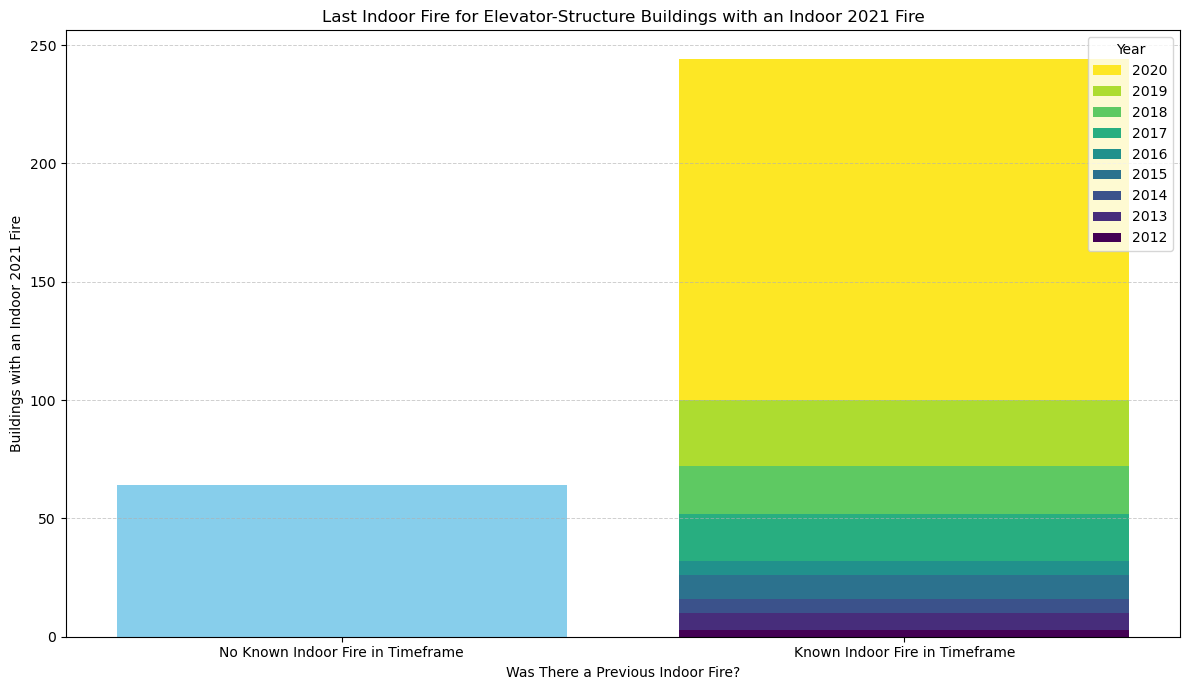

In [267]:
year = 2021
lookback = m[
    ((m[f'building_fires_{year}'] > 0)) &

    (m.building_type_code_es == 1) 
].copy()

lookback['last_fire'] = lookback.apply(get_last_building_fire, args=(year - 1,), axis=1)

lookback['last_fire'] = lookback['last_fire'].astype(str)
lookback.last_fire = lookback.last_fire.replace('-1', 'None in Timeframe')

lookbackvals = lookback.groupby('last_fire').size().reset_index()

# Separate "None After 2012" from the rest and concatenate them in the desired order
none_after_2012 = lookbackvals[lookbackvals['last_fire'] == 'None in Timeframe']
others = lookbackvals[lookbackvals['last_fire'] != 'None in Timeframe'].sort_values(by='last_fire')

lookbackvals_sorted = pd.concat([none_after_2012, others])

plt.figure(figsize=(12, 7))

none_val = none_after_2012[0].values[0]
plt.bar("No Known Indoor Fire in Timeframe", none_val, color='skyblue')

bottom_val = 0  
colors = plt.cm.viridis(np.linspace(0, 1, len(others))) 
for index, row in others.iterrows():
    plt.bar("Known Indoor Fire in Timeframe", row[0], bottom=bottom_val, color=colors[index], label=row['last_fire'])
    bottom_val += row[0]

plt.xlabel('Was There a Previous Indoor Fire?')
plt.ylabel('Buildings with an Indoor 2021 Fire')
plt.title('Last Indoor Fire for Elevator-Structure Buildings with an Indoor 2021 Fire')
plt.legend(title="Year", loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Year", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

Non-ES, 2021, any indoor fire

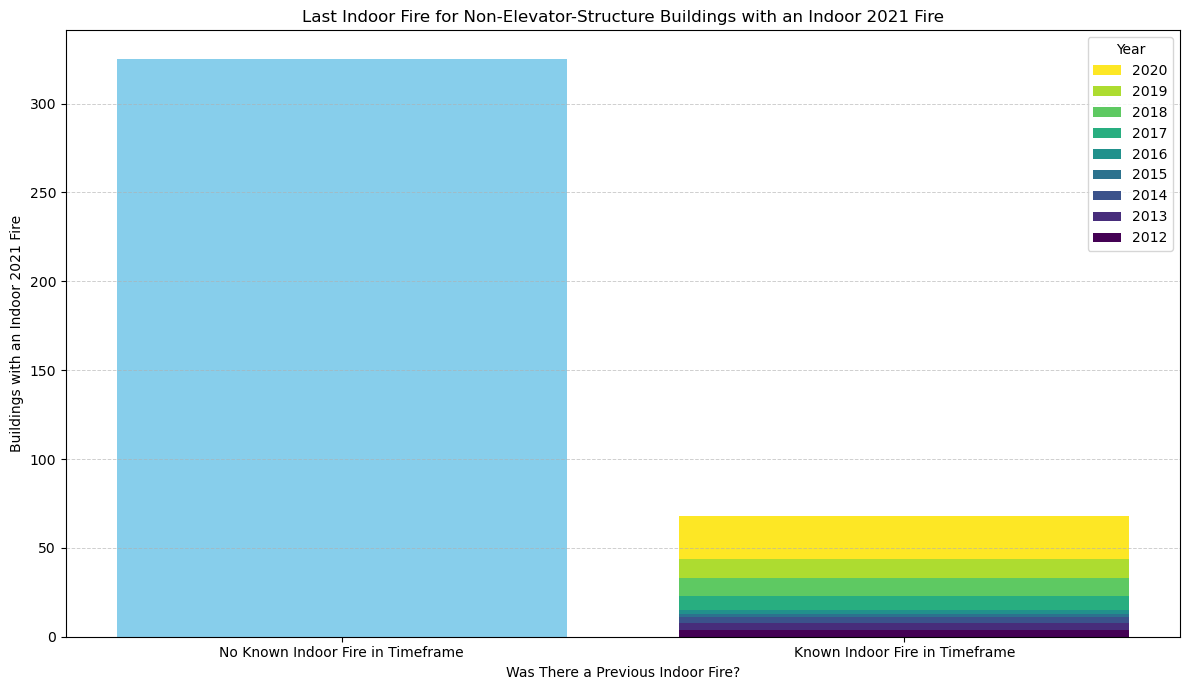

In [268]:
year = 2021
lookback = m[
    ((m[f'building_fires_{year}'] > 0)) &

    (m.building_type_code_es != 1) 
].copy()

lookback['last_fire'] = lookback.apply(get_last_building_fire, args=(year - 1,), axis=1)

lookback['last_fire'] = lookback['last_fire'].astype(str)
lookback.last_fire = lookback.last_fire.replace('-1', 'None in Timeframe')

lookbackvals = lookback.groupby('last_fire').size().reset_index()

# Separate "None After 2012" from the rest and concatenate them in the desired order
none_after_2012 = lookbackvals[lookbackvals['last_fire'] == 'None in Timeframe']
others = lookbackvals[lookbackvals['last_fire'] != 'None in Timeframe'].sort_values(by='last_fire')

lookbackvals_sorted = pd.concat([none_after_2012, others])

plt.figure(figsize=(12, 7))

none_val = none_after_2012[0].values[0]
plt.bar("No Known Indoor Fire in Timeframe", none_val, color='skyblue')

bottom_val = 0  
colors = plt.cm.viridis(np.linspace(0, 1, len(others))) 
for index, row in others.iterrows():
    plt.bar("Known Indoor Fire in Timeframe", row[0], bottom=bottom_val, color=colors[index], label=row['last_fire'])
    bottom_val += row[0]

plt.xlabel('Was There a Previous Indoor Fire?')
plt.ylabel('Buildings with an Indoor 2021 Fire')
plt.title('Last Indoor Fire for Non-Elevator-Structure Buildings with an Indoor 2021 Fire')
plt.legend(title="Year", loc='upper right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], title="Year", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

ES with at least one fire - last 10 years

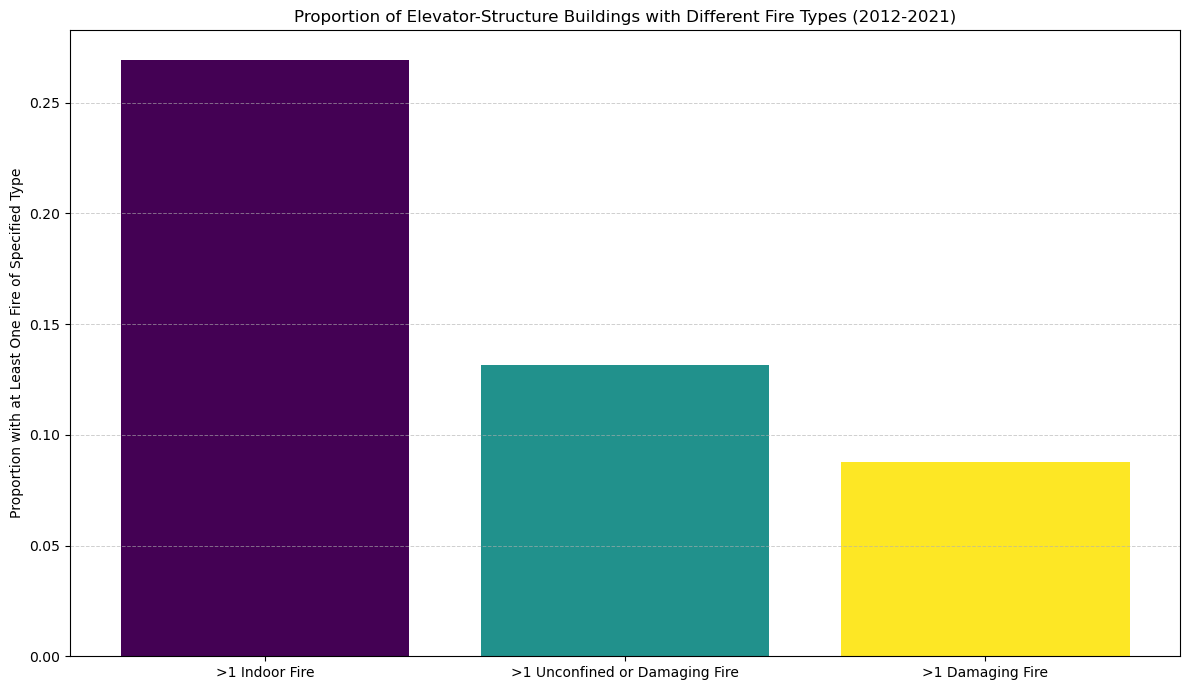

In [269]:
lookback = m[m.building_type_code_es == 1].copy()
lookback['indoor_fire'] = lookback.apply(get_last_building_fire, args=(2021,), axis=1)
lookback['unconfined_or_damage'] = lookback.apply(get_last_severe_fire, args=(2021,), axis=1)
lookback['damage'] = lookback.apply(get_last_loss_fire, args=(2021,), axis=1)

indoor_fire_proportion = lookback[lookback.indoor_fire > 0].shape[0] / len(lookback)
unconfined_or_damage_proportion = lookback[lookback.unconfined_or_damage > 0].shape[0] / len(lookback)
damage_proportion = lookback[lookback.damage > 0].shape[0] / len(lookback)

proportions = [indoor_fire_proportion, unconfined_or_damage_proportion, damage_proportion]
labels = ['>1 Indoor Fire', '>1 Unconfined or Damaging Fire', '>1 Damaging Fire']

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(proportions))) 

for i, proportion in enumerate(proportions):
    plt.bar(labels[i], proportion, color=colors[i])

plt.ylabel('Proportion with at Least One Fire of Specified Type')
plt.title('Proportion of Elevator-Structure Buildings with Different Fire Types (2012-2021)')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

ES with at least one fire 2021

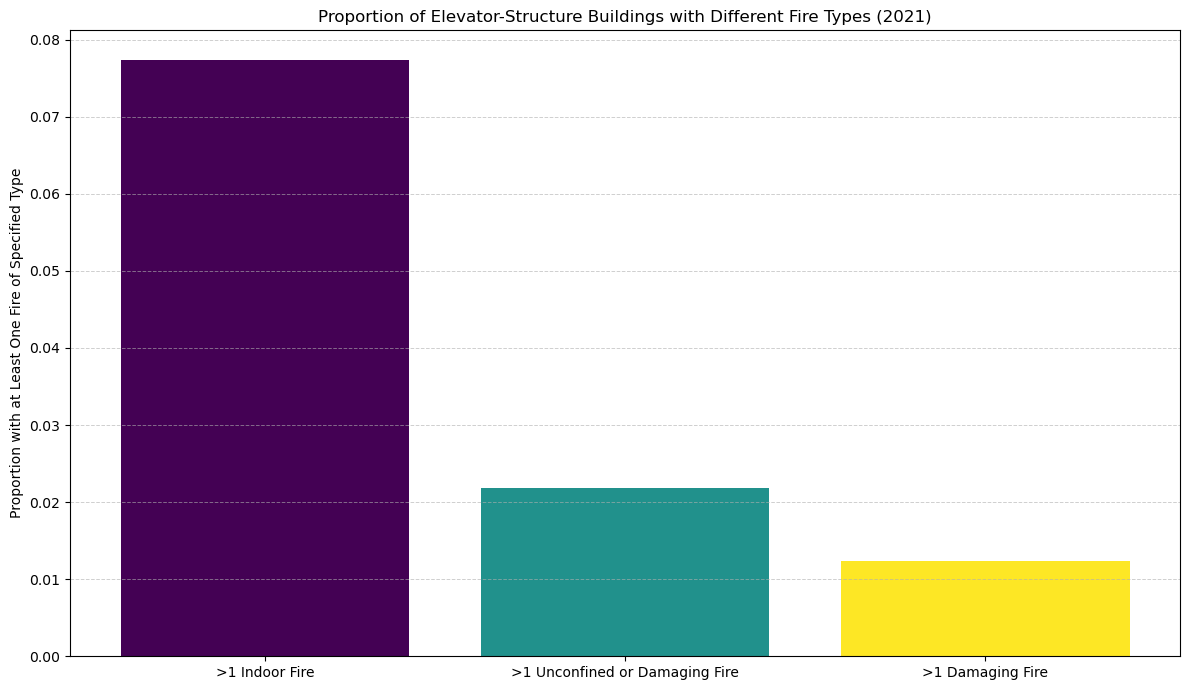

In [270]:
lookback = m[m.building_type_code_es == 1].copy()
indoor_fire_proportion = len(lookback[lookback.building_fires_2021 > 0]) / len(lookback)
unconfined_or_damage_proportion = len(lookback[
    (lookback.inc_type_111_2021 > 0) |
    (lookback.oth_death_2021 > 0) | 
    (lookback.oth_inj_2021 > 0) | 
    (lookback.prop_loss_2021 > 0) | 
    (lookback.cont_loss_2021 > 0)
]) / len(lookback)
damage_proportion = len(lookback[
    (lookback.oth_death_2021 > 0) | 
    (lookback.oth_inj_2021 > 0) | 
    (lookback.prop_loss_2021 > 0) | 
    (lookback.cont_loss_2021 > 0)
]) / len(lookback)

proportions = [indoor_fire_proportion, unconfined_or_damage_proportion, damage_proportion]
labels = ['>1 Indoor Fire', '>1 Unconfined or Damaging Fire', '>1 Damaging Fire']

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(proportions))) 

for i, proportion in enumerate(proportions):
    plt.bar(labels[i], proportion, color=colors[i])

plt.ylabel('Proportion with at Least One Fire of Specified Type')
plt.title('Proportion of Elevator-Structure Buildings with Different Fire Types (2021)')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

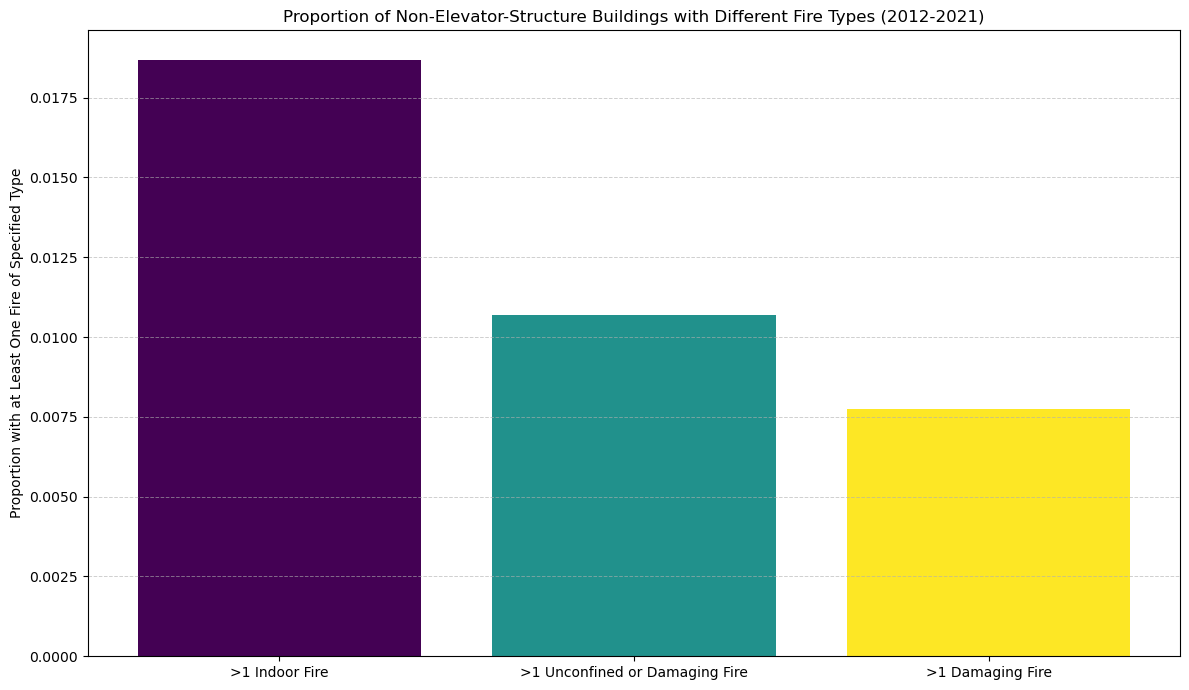

In [271]:
lookback = m[m.building_type_code_es != 1].copy()
lookback['indoor_fire'] = lookback.apply(get_last_building_fire, args=(2021,), axis=1)
lookback['unconfined_or_damage'] = lookback.apply(get_last_severe_fire, args=(2021,), axis=1)
lookback['damage'] = lookback.apply(get_last_loss_fire, args=(2021,), axis=1)

indoor_fire_proportion = lookback[lookback.indoor_fire > 0].shape[0] / len(lookback)
unconfined_or_damage_proportion = lookback[lookback.unconfined_or_damage > 0].shape[0] / len(lookback)
damage_proportion = lookback[lookback.damage > 0].shape[0] / len(lookback)

proportions = [indoor_fire_proportion, unconfined_or_damage_proportion, damage_proportion]
labels = ['>1 Indoor Fire', '>1 Unconfined or Damaging Fire', '>1 Damaging Fire']

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(proportions))) 

for i, proportion in enumerate(proportions):
    plt.bar(labels[i], proportion, color=colors[i])

plt.ylabel('Proportion with at Least One Fire of Specified Type')
plt.title('Proportion of Non-Elevator-Structure Buildings with Different Fire Types (2012-2021)')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

Non-ES, 2021, different fire types

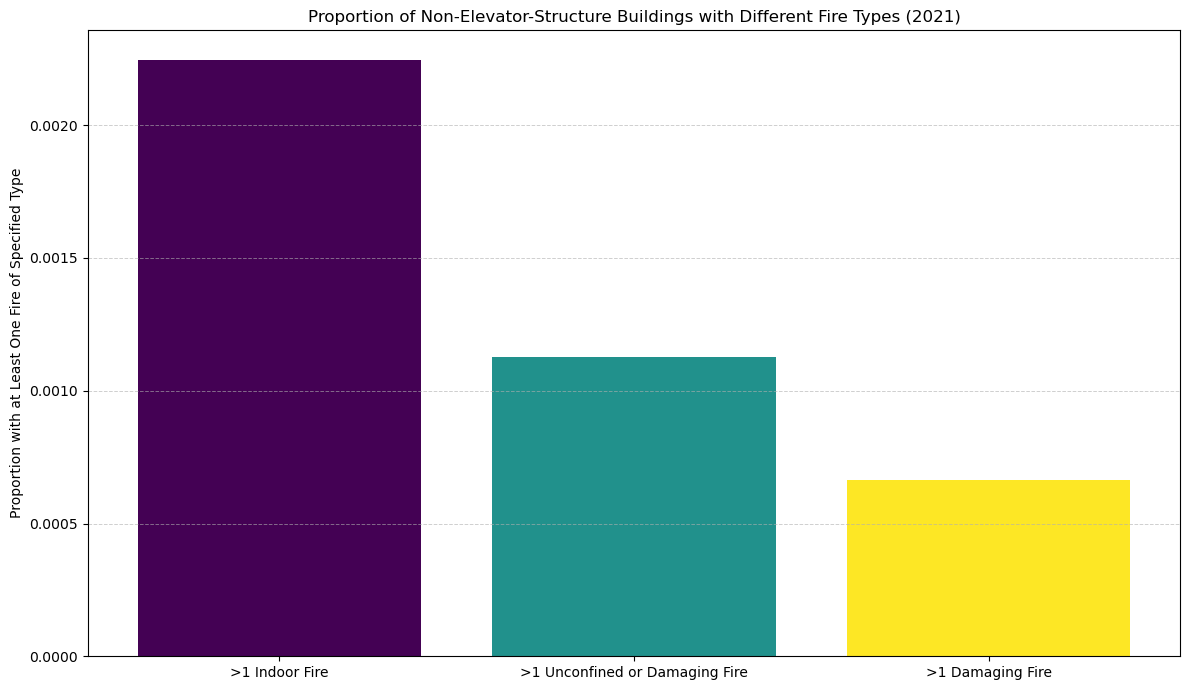

In [272]:
lookback = m[m.building_type_code_es != 1].copy()
indoor_fire_proportion = len(lookback[lookback.building_fires_2021 > 0]) / len(lookback)
unconfined_or_damage_proportion = len(lookback[
    (lookback.inc_type_111_2021 > 0) |
    (lookback.oth_death_2021 > 0) | 
    (lookback.oth_inj_2021 > 0) | 
    (lookback.prop_loss_2021 > 0) | 
    (lookback.cont_loss_2021 > 0)
]) / len(lookback)
damage_proportion = len(lookback[
    (lookback.oth_death_2021 > 0) | 
    (lookback.oth_inj_2021 > 0) | 
    (lookback.prop_loss_2021 > 0) | 
    (lookback.cont_loss_2021 > 0)
]) / len(lookback)

proportions = [indoor_fire_proportion, unconfined_or_damage_proportion, damage_proportion]
labels = ['>1 Indoor Fire', '>1 Unconfined or Damaging Fire', '>1 Damaging Fire']

plt.figure(figsize=(12, 7))
colors = plt.cm.viridis(np.linspace(0, 1, len(proportions))) 

for i, proportion in enumerate(proportions):
    plt.bar(labels[i], proportion, color=colors[i])

plt.ylabel('Proportion with at Least One Fire of Specified Type')
plt.title('Proportion of Non-Elevator-Structure Buildings with Different Fire Types (2021)')
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout()
plt.show()

### Precision-recall using simple model

              precision    recall  f1-score   support

       False       0.98      0.79      0.88      3675
        True       0.24      0.79      0.37       308

    accuracy                           0.79      3983
   macro avg       0.61      0.79      0.62      3983
weighted avg       0.92      0.79      0.84      3983



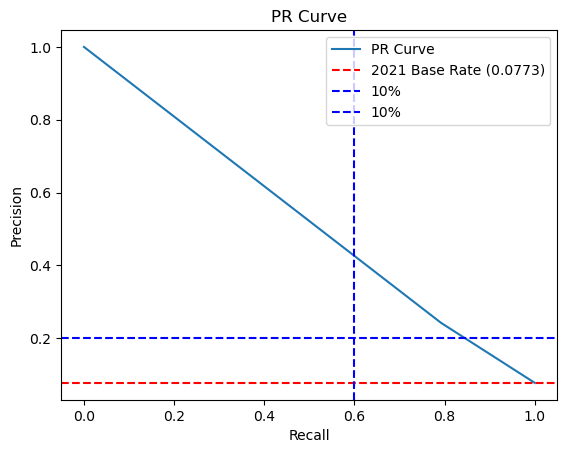

In [273]:
year = 2021
h = m[
    (m.building_type_code_es == 1)].copy()

h['y_pred_severe'] = h.apply(get_last_building_fire, args=(year - 1,), axis=1) > 0
h['y_true'] = h[f'building_fires_{year}'] > 0


# (
#     (h[f'inc_type_111_{year}'] > 0) |
#     (h[f'oth_inj_{year}'] > 0) |
#     (h[f'oth_death_{year}'] > 0) |
#     (h[f'prop_loss_{year}'] > 0) |
#     (h[f'cont_loss_{year}'] > 0)
# )



from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

report = classification_report(h.y_true, h.y_pred_severe)
print(report)

precision, recall, thresholds = precision_recall_curve(h.y_true, h.y_pred_severe)

plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
base_rate = len(h[h.y_true == True]) / len(h)
plt.axhline(base_rate, color='r', linestyle='--', label=f'2021 Base Rate ({round(base_rate, 4)})')

plt.axhline(.2, color='b', linestyle='--', label=f'10%')
plt.axvline(.6, color='b', linestyle='--', label=f'10%')

plt.legend()
plt.show()


### Quick analysis of buildings with recurring fires

In [274]:
es = m[m.building_type_code_es == 1].copy()

40% of all units are elevator structures.

In [275]:
es.total_units.sum() / m.total_units.sum()

0.39043073943091033

Even though they only include 2% of buildings.

In [276]:
len(es) / len(m)

0.022246052624229934

In [277]:
fires = [x for x in es.columns if 'building_fires_' in x]

es['had_fires'] = es[fires].sum(axis=1) > 0

type111 = [x for x in es.columns if 'inc_type_111_' in x]
prop = [x for x in es.columns if 'prop_loss' in x]
cont = [x for x in es.columns if 'cont_loss' in x]
death = [x for x in es.columns if 'oth_death' in x]
injury = [x for x in es.columns if 'oth_inj' in x]

es['had_severe_fires'] = (es[type111].sum(axis=1) > 0) | (es[prop].sum(axis=1) > 0) | (es[cont].sum(axis=1) > 0) | (es[death].sum(axis=1) > 0) | (es[injury].sum(axis=1) > 0)

es['had_fire_loss'] = (es[prop].sum(axis=1) > 0) | (es[cont].sum(axis=1) > 0) | (es[death].sum(axis=1) > 0) | (es[injury].sum(axis=1) > 0)

About a quarter of ES had a fire in the last 10 years.

In [278]:
print(es[es.had_fires].shape[0] / len(es))
print(es[es.had_severe_fires].shape[0] / len(es))
print(es[es.had_fire_loss].shape[0] / len(es))

0.2691438614109967
0.13130805925182024
0.08787346221441125


In [279]:
es[
    (es.oth_death_2021 > 0) |
    (es.oth_inj_2021 > 0) |
    (es.cont_loss_2021 > 0) |
    (es.prop_loss_2021 > 0) 

].apply(get_last_loss_fire, args=(2021 - 1,), axis=1).reset_index().groupby(0).size()


0
-1       23
 2012     2
 2013     1
 2014     1
 2015     2
 2016     2
 2017     4
 2018     5
 2019     7
 2020     2
dtype: int64

In [280]:
corrs = []
for col in es.select_dtypes(include='number').columns:
    if es[col].isna().sum() / len(es) < .9 and '2012' not in col and '2013' not in col and '2014' not in col and '2015' not in col and '2016' not in col and '2017'  not in col and '2018' not in col and '2019' not in col and '2020' not in col and '2021' not in col:
        corrs.append((col, es[col].corr(es.had_fires)))
corrs = pd.DataFrame(corrs, columns=['col', 'corr'])

pd.set_option('display.max_rows', 45)
display(corrs.dropna().sort_values('corr').tail(45))
pd.set_option('display.max_rows', 10)

,col,corr
103,dev_pct_lt30_median,0.158722
28,pct_lt30_median,0.160616
196,pha_ha_combined_size_category_medium high (300...,0.164467
201,pha_phas_designation_high performer,0.164600
200,pha_phas_designation_advisory,0.171708
216,apt_type_missing_value,0.173384
39,pct_age62plus,0.174382
265,std_st_il,0.174967
46,months_waiting,0.176036
161,msgusps_70% overall probable correctness,0.177534


### MC simulation

In [281]:
es = m[m.building_type_code_es == 1].copy()
# rate = len(es[
#     (es.oth_death_2021 > 0) |
#     (es.oth_inj_2021 > 0) |
#     (es.prop_loss_2021 > 0) |
#     (es.cont_loss_2021 > 0) 
# ]) / len(es)
rate = len(es[
    (es.building_fires_2021 > 0)
]) / len(es)
population_size = len(es)
print(population_size, rate)

3983 0.0773286467486819


Text(0.5, 0, 'Number of Overlapping Fires in Random Simulation')

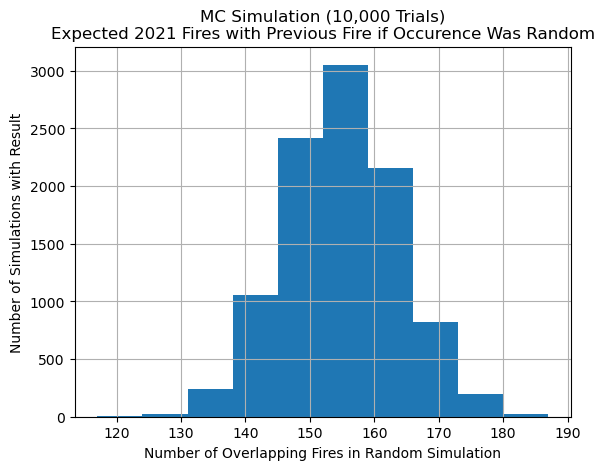

In [282]:
import random

years = 9
counts = []
for i in range(10000):
    espop = [0 for x in range(population_size)]
    for x in range(int(population_size * rate * years)):  
        rand_index = random.randint(1, population_size - 1)
        espop[rand_index] += 1

    count = 0
    for x in range(int(population_size * rate)): 
        rand_index = random.randint(1, population_size - 1)
        if espop[rand_index] > 0:
            count += 1
    counts.append(count)

pd.DataFrame(counts).hist(bins=10)
plt.title('MC Simulation (10,000 Trials)\nExpected 2021 Fires with Previous Fire if Occurence Was Random')
plt.ylabel('Number of Simulations with Result')
plt.xlabel('Number of Overlapping Fires in Random Simulation')

### Differences in buildings with some fires

In [283]:
m = pd.read_csv('./ph_fires_matched_1.1.csv')

In [284]:
es = m[m.building_type_code_es == 1].copy()
nes = m[m.building_type_code_es != 1].copy()

In [285]:
fires = [x for x in es.columns if 'building_fires_' in x]
es['total_fires'] = es[fires].sum(axis=1)
es['yes_total_fires'] = es.total_fires > 0

prop = [x for x in es.columns if 'prop_loss_' in x]
cont = [x for x in es.columns if 'cont_loss_' in x]
injury = [x for x in es.columns if 'oth_inj_' in x]
death = [x for x in es.columns if 'oth_death_' in x]
es['loss_fires'] = es[prop].sum(axis=1) + es[cont].sum(axis=1) + es[injury].sum(axis=1) + es[death].sum(axis=1)
es['yes_loss_fires'] = es.loss_fires > 0

In [286]:
nes['total_fires'] = nes[fires].sum(axis=1)
nes['yes_total_fires'] = nes.total_fires > 0
nes['loss_fires'] = nes[prop].sum(axis=1) + nes[cont].sum(axis=1) + nes[injury].sum(axis=1) + nes[death].sum(axis=1)
nes['yes_loss_fires'] = nes.loss_fires > 0

In [287]:
corrs = []
for col in es.select_dtypes(include='number').columns:
    if es[col].isna().sum() / len(es) < .9 and '2012' not in col and '2013' not in col and '2014' not in col and '2015' not in col and '2016' not in col and '2017'  not in col and '2018' not in col and '2019' not in col and '2020' not in col and '2021' not in col:
        corrs.append((col, es[col].corr(es.yes_loss_fires)))
corrs = pd.DataFrame(corrs, columns=['col', 'corr'])

pd.set_option('display.max_rows', 45)
display(corrs.dropna().sort_values('corr').head(45))
pd.set_option('display.max_rows', 10)

,col,corr
101,dev_pct_median,-0.256671
106,dev_pct_female_head,-0.253082
31,pct_female_head,-0.251528
97,dev_pct_ge20k,-0.249494
81,dev_pha_total_units,-0.248773
67,pha_total_units,-0.248773
89,dev_rent_per_month,-0.248442
136,pha_capfund_amnt,-0.248292
134,pha_opfund_amnt,-0.247943
135,pha_opfund_amnt_prev_yr,-0.247895


In [288]:
corrs = []
for col in nes.select_dtypes(include='number').columns:
    if nes[col].isna().sum() / len(nes) < .9 and '2012' not in col and '2013' not in col and '2014' not in col and '2015' not in col and '2016' not in col and '2017'  not in col and '2018' not in col and '2019' not in col and '2020' not in col and '2021' not in col:
        corrs.append((col, nes[col].corr(nes.yes_total_fires)))
corrs = pd.DataFrame(corrs, columns=['col', 'corr'])

pd.set_option('display.max_rows', 45)
display(corrs.dropna().sort_values('corr').tail(45))
pd.set_option('display.max_rows', 10)

,col,corr
113,"pha_ha_section_8_size_category_extra large (5,...",0.025924
214,std_st_ma,0.026265
86,pha_pct_disabled_lt62_all,0.026853
66,dev_months_from_movein,0.027244
23,dev_total_occupied,0.028900
33,dev_rent_per_month,0.029089
27,dev_number_reported,0.029396
50,dev_pct_female_head,0.029886
60,dev_pct_minority,0.030052
22,dev_acc_units,0.030616


In [289]:
col = 'pct_bed1'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.05046447401456189
89.92157785120315


52.40552386369942

In [290]:
col = 'pct_10k_lt15k'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.05046447401456189
50.712110432140044


36.396831652062865

In [291]:
col = 'pct_disabled_all'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.05046447401456189
55.360966453856015


41.658312870498555

In [292]:
col = 'eldly_prcnt'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.05046447401456189
57.61928003876726


40.53468567100072

In [293]:
col = 'construction_year'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.13457193070549836
1975.9093137254902


1966.3192702394526

In [294]:
col = 'pct_welfare_major'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.05046447401456189
1.0275542402268245


5.601336712955202

In [295]:
col = 'hh_income'
print(es[col].isna().sum() / len(es))
print(es[es.total_fires > 0][col].mean())
es[es.total_fires == 0][col].mean()

0.05046447401456189
14585.097633136094


20031.860910404623

In [298]:
es.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'eldly_prcnt', 
    'pct_disabled_all',
    'pct_disabled_lt62',
    'pct_10k_lt15k',
].mean()

C:\Users\jackv\AppData\Local\Temp\ipykernel_15608\2350781281.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  es.groupby(['yes_total_fires', 'yes_loss_fires'])[


eldly_prcnt  pct_disabled_all  \
yes_total_fires yes_loss_fires                                  
False           False             40.534686         41.658313   
True            False             58.282747         53.248169   
                True              56.219080         59.819877   

                                pct_disabled_lt62  pct_10k_lt15k  
yes_total_fires yes_loss_fires                                    
False           False                   45.153642      36.396832  
True            False                   66.912616      49.969535  
                True                    71.827331      52.279264

C:\Users\jackv\AppData\Local\Temp\ipykernel_15608\3433087723.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = es.groupby(['yes_total_fires', 'yes_loss_fires'])[


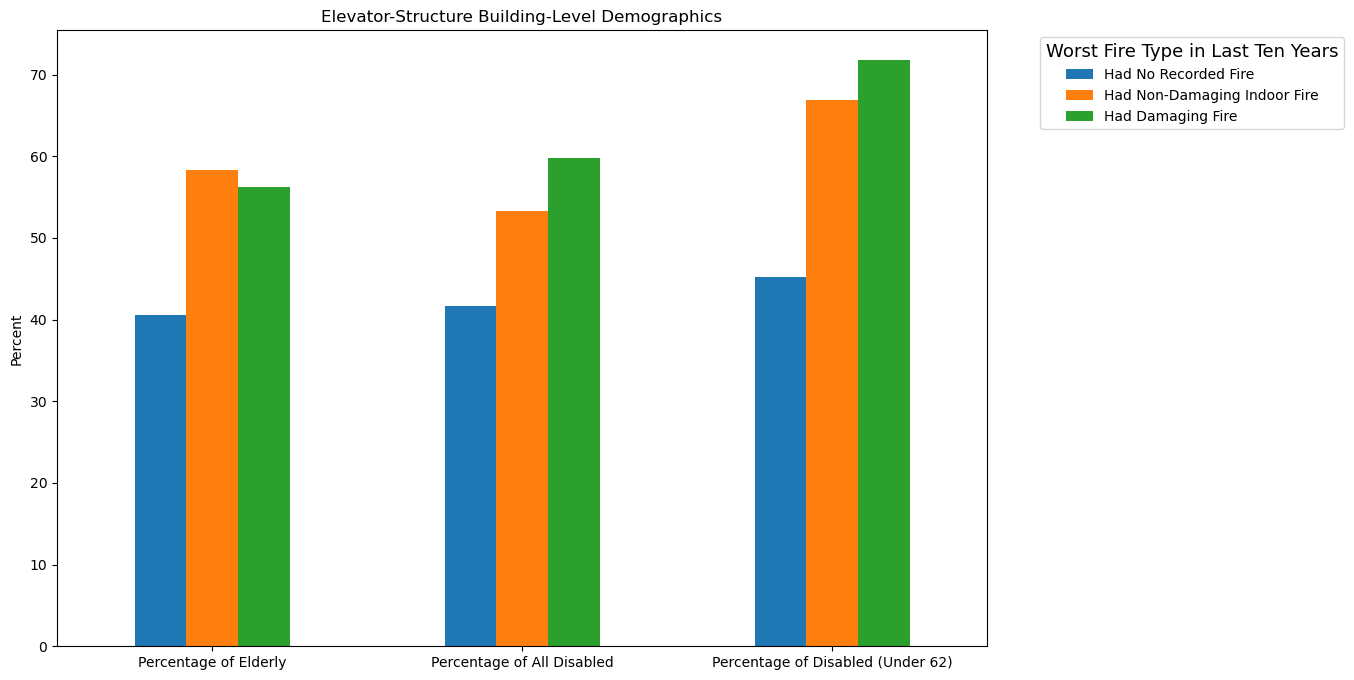

In [305]:
df = es.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'eldly_prcnt', 
    'pct_disabled_all',
    'pct_disabled_lt62',
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'eldly_prcnt': 'Percentage of Elderly',
    'pct_disabled_all': 'Percentage of All Disabled',
    'pct_disabled_lt62': 'Percentage of Disabled (Under 62)'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Elevator-Structure Building-Level Demographics')
plt.ylabel('Percent')
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

    'pct_10k_lt15k',
        'pct_bed1',

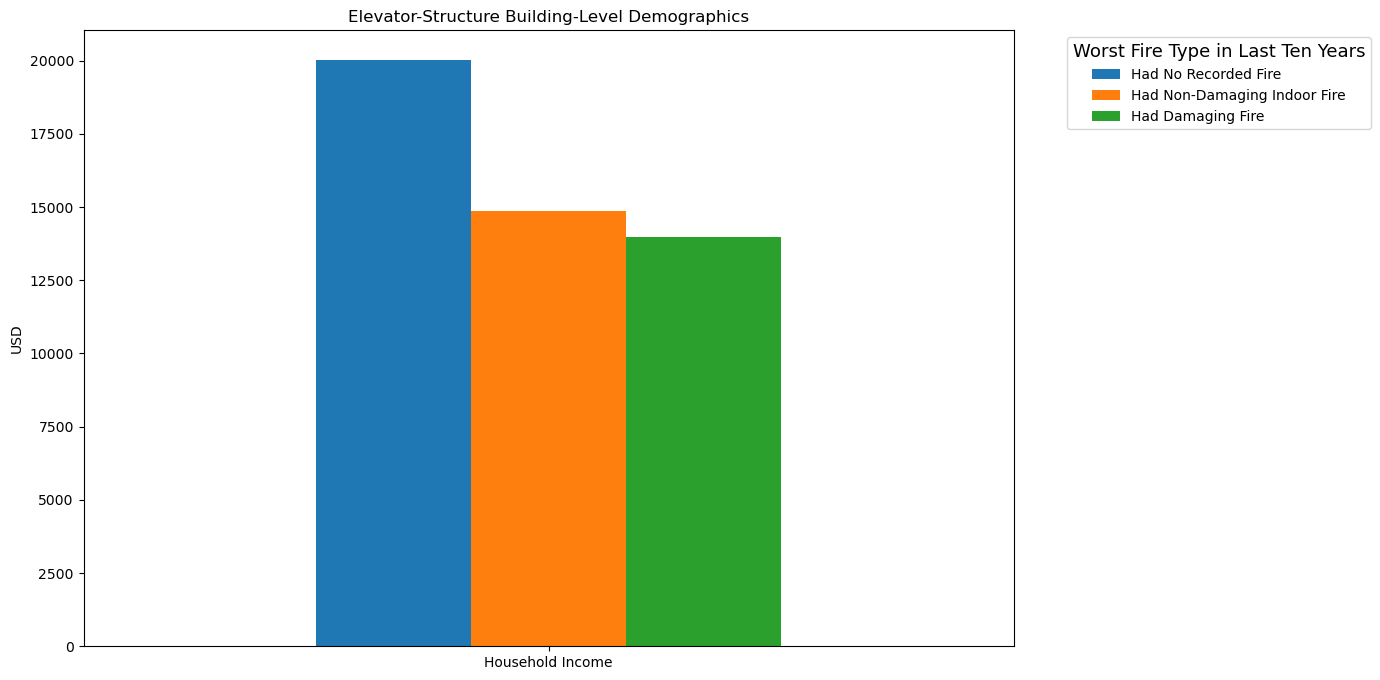

In [309]:
df = es.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'hh_income'
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'hh_income': 'Household Income'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Elevator-Structure Building-Level Demographics')
plt.ylabel('USD')
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

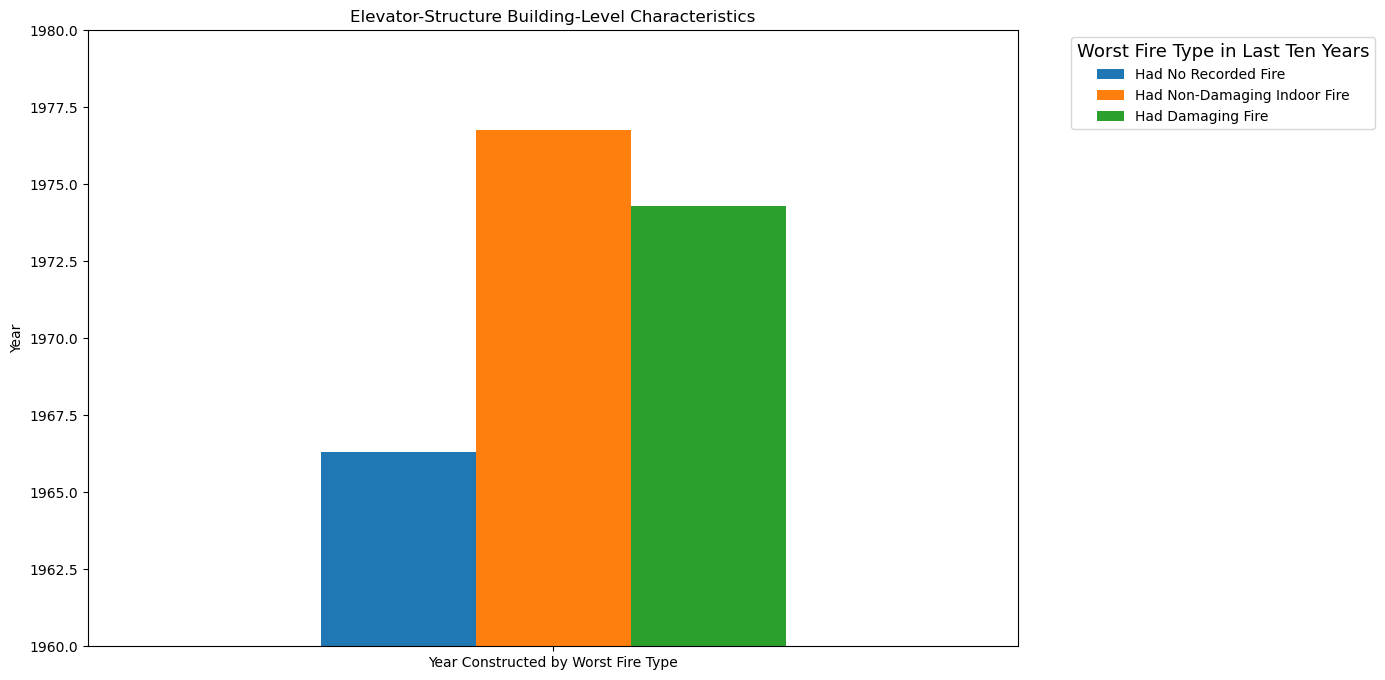

In [323]:
df = es.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'construction_year'
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'construction_year': 'Year Constructed by Worst Fire Type'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Elevator-Structure Building-Level Characteristics')
plt.ylabel('Year')
plt.ylim(1960, 1980)
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [328]:
nes.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'construction_year'
].mean().reset_index()


,yes_total_fires,yes_loss_fires,construction_year
0,False,False,1936.835603
1,True,False,1972.439446
2,True,True,1975.006318


In [337]:
nes.dev_eldly_prcnt.info()

<class 'pandas.core.series.Series'>
Int64Index: 175060 entries, 0 to 179042
Series name: dev_eldly_prcnt
Non-Null Count   Dtype  
--------------   -----  
170542 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


C:\Users\jackv\AppData\Local\Temp\ipykernel_15608\675305190.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = nes.groupby(['yes_total_fires', 'yes_loss_fires'])[


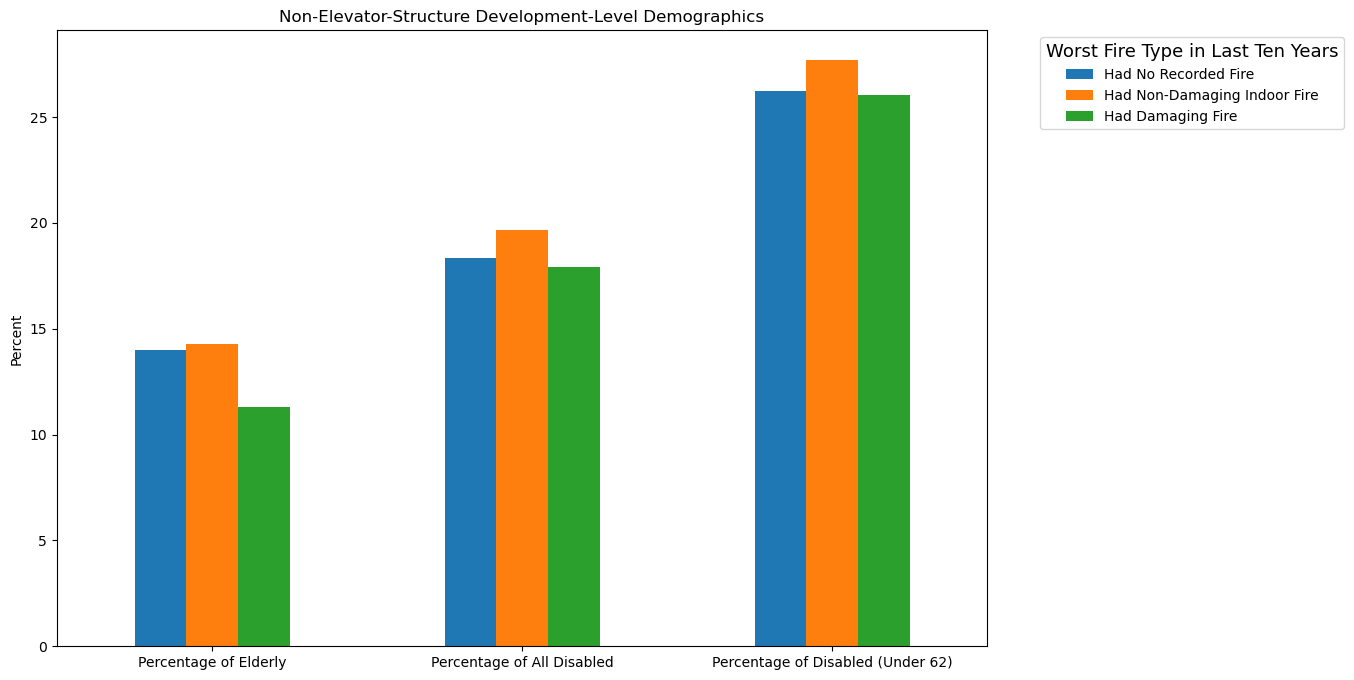

In [338]:
df = nes.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'dev_eldly_prcnt', 
    'dev_pct_disabled_all',
    'dev_pct_disabled_lt62',
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'dev_eldly_prcnt': 'Percentage of Elderly',
    'dev_pct_disabled_all': 'Percentage of All Disabled',
    'dev_pct_disabled_lt62': 'Percentage of Disabled (Under 62)'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Non-Elevator-Structure Development-Level Demographics')
plt.ylabel('Percent')
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

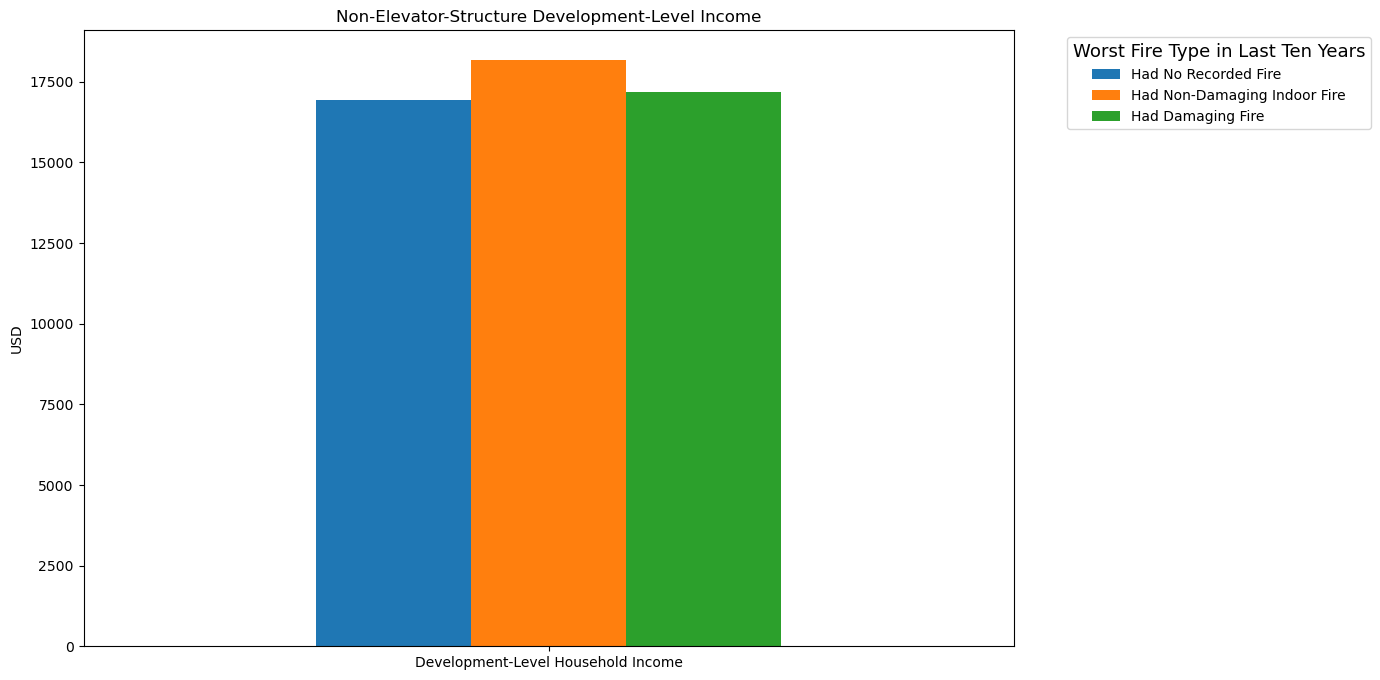

In [335]:
df = nes.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'dev_hh_income'
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'dev_hh_income': 'Development-Level Household Income'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Non-Elevator-Structure Development-Level Income')
plt.ylabel('USD')
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

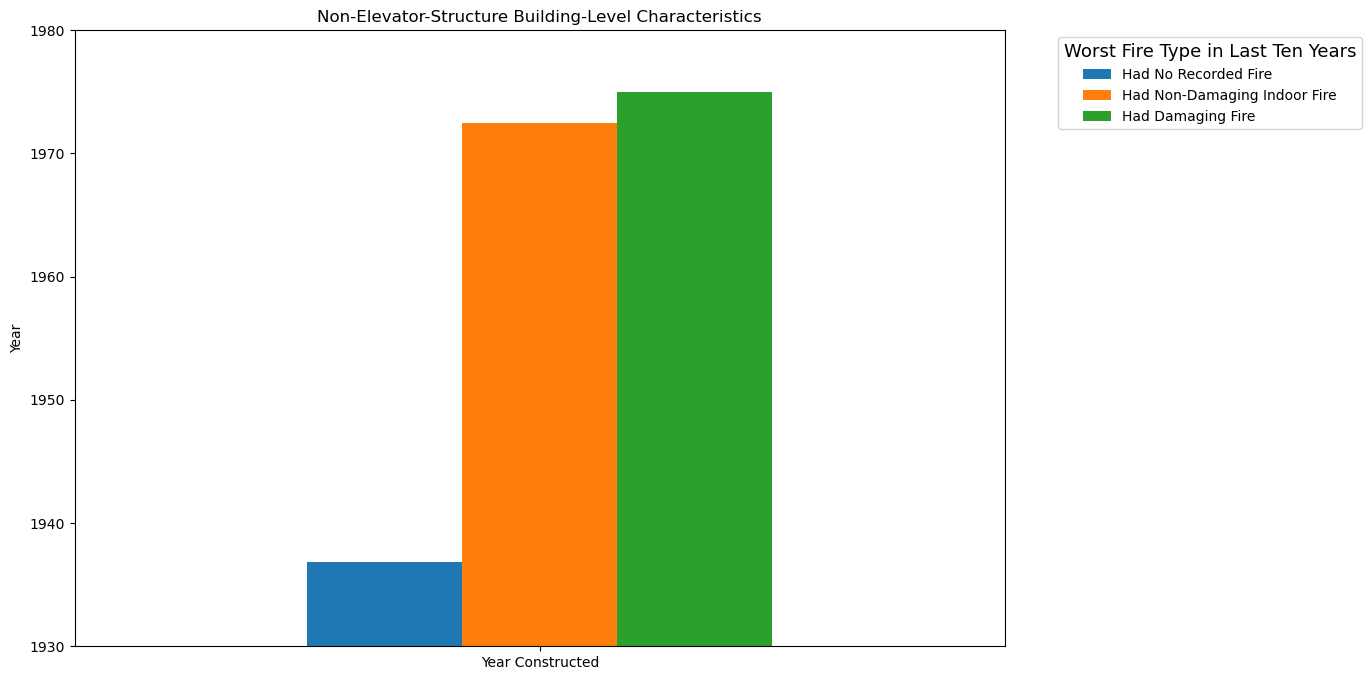

In [331]:
df = nes.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'construction_year'
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'construction_year': 'Year Constructed'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Non-Elevator-Structure Building-Level Characteristics')
plt.ylabel('Year')
plt.ylim(1930, 1980)
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

C:\Users\jackv\AppData\Local\Temp\ipykernel_15608\2833437858.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = nes.groupby(['yes_total_fires', 'yes_loss_fires'])[


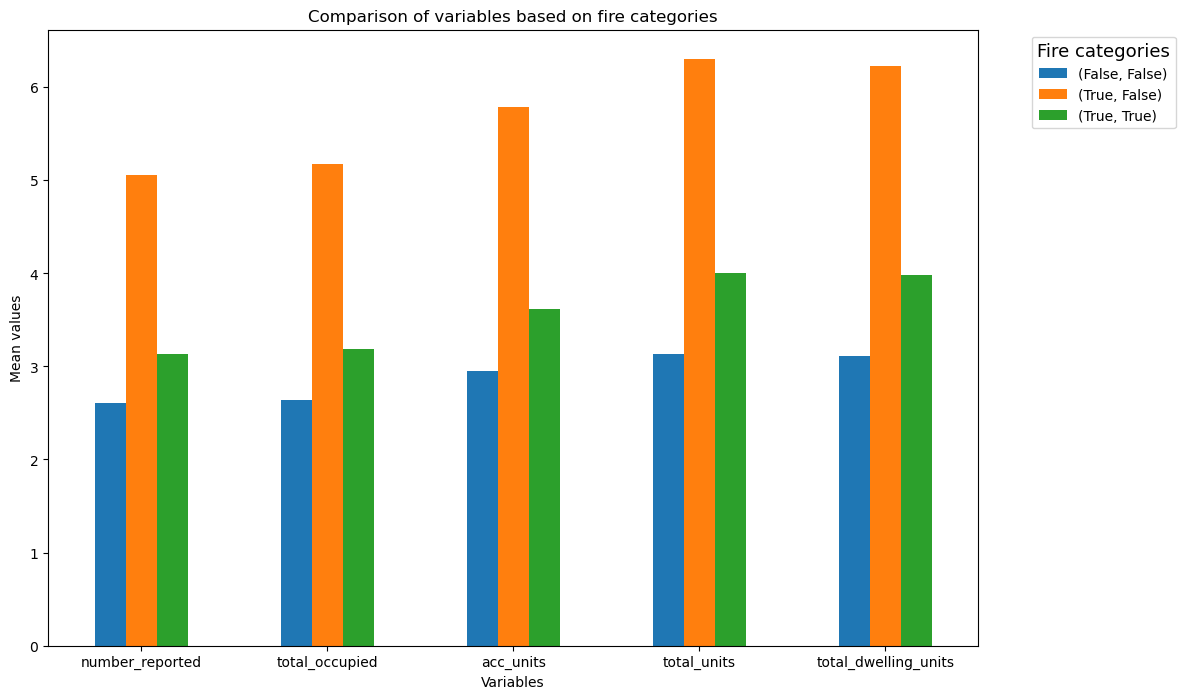

In [ ]:
df = es.groupby(['yes_total_fires', 'yes_loss_fires'])[
    'hh_income'
].mean().reset_index()

# Function to rename the grouped categories
def rename_fire_categories(row):
    if not row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had No Recorded Fire'
    elif row['yes_total_fires'] and not row['yes_loss_fires']:
        return 'Had Non-Damaging Indoor Fire'
    else:
        return 'Had Damaging Fire'

df['fire_category'] = df.apply(rename_fire_categories, axis=1)

# Set index
df.set_index(['fire_category'], inplace=True)

# Drop original boolean columns since they're now redundant
df.drop(columns=['yes_total_fires', 'yes_loss_fires'], inplace=True)

# Transpose the DataFrame for plotting
df_T = df.T

# Renaming the indices for clarity on the chart
df_T = df_T.rename(index={
    'eldly_prcnt': 'Percentage of Elderly',
    'pct_disabled_all': 'Percentage of All Disabled',
    'pct_disabled_lt62': 'Percentage of Disabled (Under 62)'
})

# Plot the bar chart
df_T.plot(kind='bar', figsize=(12, 8))

plt.title('Elevator-Structure Building-Level Demographics')
plt.ylabel('USD')
plt.xticks(rotation=0)
plt.legend(title='Worst Fire Type in Last Ten Years', title_fontsize='13', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

'rent_per_month',
    'pct_overhoused',
    'people_per_unit'